# Sequence to Sequence models for sugar level prediction

For the first part, which make use of Recurrent Neural Networks, 
take a look at https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

The second part (to be done) will use the more advanced Transformer arquitecture. 

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf

In [0]:
from tensorflow.keras.layers import Dense, LSTM, Input, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MAE
from tensorflow.keras.metrics import MAPE, MSE
from tensorflow.keras.backend import clear_session
from tensorflow.keras.constraints import max_norm

## Data preprocessing

### Load datasets

Each dataset consits of sequences of `history`+`future` points, with 4 features: 

* time interval: days counted starting from the end of the `history` of the sequence. Thus, for points in the `history`, this feature takes negatuve values, while for points in the `future`, it's positive. 
* hour: hour of the day, divided by 24.
* day of week: day of the week in numbers ('Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6), divided by 7.
* sugar level: recorded sugar level, scaled with min/max scaler.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!ls -lrth '/content/drive/My Drive/Colab Notebooks/sugar_level_prediction/data/'

total 1.2G
-rw------- 1 root root 121M Dec  9 18:46 noisy0.0_train.npy
-rw------- 1 root root  16M Dec  9 18:46 noisy0.0_test.npy
-rw------- 1 root root  16M Dec  9 18:46 noisy0.0_vad.npy
-rw------- 1 root root 2.2M Dec 16 11:53 patient1_measurements.csv
-rw------- 1 root root 9.2M Dec 16 11:53 patient0_measurements.csv
-rw------- 1 root root 611M Dec 18 10:22 noise_0.1_train_replace_True.npy
-rw------- 1 root root  26M Dec 18 10:22 noise_0.1_vad_replace_True.npy
-rw------- 1 root root  25M Dec 18 10:22 noise_0.1_test_replace_True.npy
-rw------- 1 root root 565K Dec 23 13:25 patient2_measurements.csv
-rw------- 1 root root  35M Dec 25 12:54 noise_0.0_vad_replace_False.npy
-rw------- 1 root root  34M Dec 25 12:54 noise_0.0_test_replace_False.npy
-rw------- 1 root root 285M Dec 25 12:54 noise_0.0_train_replace_False.npy


In [0]:
root = "/content/drive/My Drive/Colab Notebooks/sugar_level_prediction/data/"
noise=0.0
history = 48 * 4
future = 3 * 4

noise=0.0
replace=False

train = np.load(os.path.join(root, "noise_%s_train_replace_%s.npy" %(noise, replace)))
vad = np.load(os.path.join(root, "noise_%s_vad_replace_%s.npy" %(noise, replace)))
test = np.load(os.path.join(root, "noise_%s_test_replace_%s.npy" %(noise, replace)))

train_batch = 500
vad_batch = 500
test_batch = 500

train_steps = train.shape[0] // train_batch
vad_steps = vad.shape[0] // train_batch
test_steps = test.shape[0] // test_batch

In [7]:
history+future

204

In [8]:
train.shape, vad.shape, test.shape

((91260, 204, 4), (11190, 204, 4), (10828, 204, 4))

In [0]:
np.random.seed(1203)
np.random.shuffle(train)

In [10]:
train.shape

(91260, 204, 4)

###  Split data 

Each input sequence has both the features and labels (x and y, if you wish), so we have to separate them.

In [0]:
def split_features_labels(data, history, future, start_char):
    """
    Method to separate historic and future events (features and labels). 
    It returns input data for the encoder and decoder, and the output data 
    for the decoder. The input data for the decoder is just the output data 
    of the decoder, shifted by one step. 

    :param data: numpy ndarray with sequences of history+future points, and 4 attributes 
      (time_interval, hour_of_day, day_of_week, sugar_level). It has shape (?, history+future, 4)
    :param history: number of points for the features
    :param future: number of points for the labels
    :param start_char: start charcter for input sequences to the decoder
    :return three numpy arrays with the input data for the encoder (shape=(?, history, 4))
        and decoder (shape=(?, future+1, 1)), and the output data for the decoder
        (shape=(?, future+1, 1))
    """
    # split features and labels . Note that for the later, we only keep the 
    # feature with the sugar level, which constitutes our target
    yf, yl = data[:, :history], data[:, history:history+future, -1]
    
    # add start of sentence to labels (input to the decoder)
    yl_input = start_char * np.ones(shape=(yl.shape[0], yl.shape[1]+1))
    yl_input[:, 1:] = yl
    # add end of sentence to labels (output of the decoder)
    yl_output = start_char * np.ones(shape=(yl.shape[0], yl.shape[1]+1))
    yl_output[:, :-1] = yl
    
    # add new dimension at the end of input/output arrays to the decoder
    yl_input = yl_input[:, :, np.newaxis].astype(np.float32)
    yl_output = yl_output[:, :, np.newaxis].astype(np.float32)
    
    return (yf, yl_input), yl_output

In [0]:
start_char = -1.0
train_data = split_features_labels(train, history, future, start_char)
vad_data = split_features_labels(vad, history, future, start_char)
test_data = split_features_labels(test, history, future, start_char)

In [13]:
train_data[0][0].shape, train_data[0][1].shape, train_data[1].shape

((91260, 192, 4), (91260, 13, 1), (91260, 13, 1))

## Some auxiliar functions 



In [0]:
def plot_train_history(history, title, metric):
  loss = history[metric]
  val_loss = history['val_%s' %metric]

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training %s' %metric)
  plt.plot(epochs, val_loss, 'r', label='Validation %s' %metric)
  plt.title(title)
  plt.legend()

  plt.yscale('log')
  plt.show()

def plot_results(dataset, prediction, history, future):
    plt.figure(figsize=(12, 6))

    # get random idx
    idx = np.random.randint(0, dataset.shape[0])

    # get intervals
    xf = dataset[idx, :history, 0]
    xl = dataset[idx, history:history+future, 0]
    
    # get sequences
    input_seq_ = dataset[idx, :history, -1]
    target_seq_ = dataset[idx, history:history+future, -1]
    decoded_seq_ = prediction[idx, :]

    ymin = input_seq_.min()-0.1
    ymax = input_seq_.max()+0.1
    
    plt.plot(xf, input_seq_, '-b', markersize=2, linewidth=2, label='historic data')
    plt.plot(xl, target_seq_, '.--b', markersize=2, linewidth=2, label='future data')
    plt.plot(xl, decoded_seq_, '.--k', markersize=2, linewidth=2, label='prediction')
    plt.vlines(x=0, ymin=ymin, ymax=ymax, colors='k', linewidth=1, linestyles='--')

    plt.ylim(ymin, ymax)
    plt.xlim(-0.3-history/4/24, future/4/24+0.3)
    
    plt.ylabel('Glucose evolution (arb.units)')
    plt.xlabel('Days before/after start prediction')
    plt.legend(loc='best')

    plt.show()

In [0]:
def mae(dataset, prediction, history, future):
    expected = dataset[:, history:history+future, -1]
    return np.mean(np.abs(expected - prediction))

def plot_metric(arr):
    x = arr[:, 0]
    y = arr[:, 1]
    z = arr[:, 2]
    
    plt.figure()
    plt.title('MAE error')
    plt.plot(x, y,  '.--k', markersize=5, linewidth=2, label='train')
    plt.plot(x, z,  '.--b', markersize=5, linewidth=2, label='val')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Average Error')
    plt.legend(loc='best')
    plt.show()

## Seq2Seq model (simple)

### Model

In [0]:
def encoder(latent_dim, num_features, num_layers, mn_rec, dropout, recurrent_dropout):
    """
    Encode sequences with LSTMs 

    :param latent_dim: dimension of the encoding vectors
    :param num_features: number of input features
    :param num_layers: number of stack layers. Last layer only returns states
    :param mn_rec: max norm value used in the recurrent layers
    :param dropout: Float between 0 and 1. Fraction of the units to drop for the 
        linear transformation of the inputs.
    :param recurrent_dropout: Float between 0 and 1. Fraction of the units to 
        drop for the linear transformation of the recurrent state.
    :return encoder input and output states, and last output of the sequence
    """
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None, num_features))

    # for loop to stack lstms, with returning sequences
    input_ = encoder_inputs
    for i in np.arange(num_layers-1):
       lstm_ = LSTM(latent_dim, return_sequences=True, 
                    kernel_constraint=max_norm(mn_rec),
                    recurrent_constraint=max_norm(mn_rec), dropout=dropout, 
                   recurrent_dropout=recurrent_dropout)
       input_ = lstm_(input_)

    # the last lstm returns the states, which will be use to feed the decoder
    encoder = LSTM(latent_dim, return_state=True, 
                   kernel_constraint=max_norm(mn_rec), 
                   recurrent_constraint=max_norm(mn_rec), dropout=dropout, 
                   recurrent_dropout=recurrent_dropout)
    encoder_output, state_h, state_c = encoder(input_)
    encoder_states = [state_h, state_c]

    return encoder_inputs, encoder_states, encoder_output

def decoder(encoder_states, encoder_output, latent_dim, future_steps,
            activation_dense, mn_dense, mn_rec, 
            dropout, recurrent_dropout):
    """
    Decoder with LSTM 
    
    :param encoder_satates: list of tensors with the LSTM states (cell and hidden)
    :param encoder_output: last output of the sequence
    :param latent_dim: dimension of the decoding vectors
    :param future_steps: number of predictions. 
    :param activation_dense: activation used in the last dense layer
    :param mn_dense: max norm value used in the dense layer
    :param mn_rec: max norm value used in the recurrent layers
    :param dropout: Float between 0 and 1. Fraction of the units to drop for the 
        linear transformation of the inputs.
    :param recurrent_dropout: Float between 0 and 1. Fraction of the units to 
        drop for the linear transformation of the recurrent state.
    :return decoder input and output sequences
    """
    # use encoder_output as input to the decoder
    decoder_inputs = RepeatVector(future_steps)(encoder_output)

    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the 
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, 
                        kernel_constraint=max_norm(mn_rec), 
                        recurrent_constraint=max_norm(mn_rec), dropout=dropout, 
                        recurrent_dropout=recurrent_dropout)
    lstm_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    
    decoder_dense = Dense(latent_dim // 4, activation='selu', kernel_constraint=max_norm(mn_dense))
    decoder_dense_out = decoder_dense(lstm_outputs)
    decoder_dense2 = Dense(latent_dim // 16, activation='selu', kernel_constraint=max_norm(mn_dense))
    decoder_dense2_out = decoder_dense2(decoder_dense_out)
    decoder_dense3 = Dense(1, activation='selu', kernel_constraint=max_norm(mn_dense))
    decoder_outputs = decoder_dense3(decoder_dense2_out)
     
    return decoder_inputs, decoder_outputs

def seq2seq(history, future, latent_dim, num_features, num_layers_enc,
            activation_dense, mn_dense, mn_rec, dropout, recurrent_dropout):
    """

    :param history: number of steps of input sequence
    :param future: number of steps of output sequence
    :param latent_dim: dimension of the encoding/decoding vectors
    :param num_features: number of input features
    :param num_layers_enc: number of stack layers in the encoder. 
      Last layer only returns states
    :param activation_dense: activation used in the last dense layer
    :param mn_dense: max norm value used in the dense layer
    :param mn_rec: max norm value used in the recurrent layers
    :param dropout: Float between 0 and 1. Fraction of the units to drop for the 
        linear transformation of the inputs.
    :param recurrent_dropout: Float between 0 and 1. Fraction of the units to 
        drop for the linear transformation of the recurrent state.
    :return the model
    """
    clear_session()

    # encode
    encoder_inputs, encoder_states, encoder_output = encoder(latent_dim, 
        num_features, num_layers_enc, mn_rec, dropout, recurrent_dropout)

    # decode
    decoder_inputs, decoder_outputs = decoder(
        encoder_states, encoder_output, latent_dim, future,
        activation_dense, mn_dense, mn_rec, dropout, recurrent_dropout)

    # Training model
    model = Model(inputs=encoder_inputs, outputs=decoder_outputs, 
                  name='seq2seq_training_model')
    print(model.summary())

    return model

### Training

In [0]:
def train_seq2seq(train_data, vad_data, train, vad, history, future, start_char, 
                  latent_dim, num_features, num_layers_enc, 
                  activation_dense, mn_dense, mn_rec, dropout, recurrent_dropout, 
                  lr, clip_value, num_epochs, train_batch, loss, metric, verbose):

    m = seq2seq(history, future, latent_dim=neurons, num_features=num_features, 
                num_layers_enc=num_layers_enc, activation_dense=activation_dense, 
                mn_dense=mn_dense, mn_rec=mn_rec, 
                dropout=dropout, recurrent_dropout=recurrent_dropout)

    m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr, clipvalue=clip_value), 
              loss=loss, metrics=[metric])

    # we remove the end of sentence from target data (used in more complicated models)
    input_train = train_data[0][0]
    target_train = train_data[1][:, :-1]

    input_vad = vad_data[0][0]
    target_vad = vad_data[1][:, :-1]

    h = m.fit(x=input_train, y=target_train, batch_size=train_batch, epochs=num_epochs, 
              validation_data=(input_vad, target_vad))
    
    training_logs = h.history

    # get predictions for the validation set
    prediction_vad = m.predict(input_vad, batch_size=500, verbose=True)

    for _ in np.arange(4):
        plot_results(vad, prediction_vad, history, future)

    plot_train_history(training_logs, 'Seq2Seq', metric='loss')
    plot_train_history(training_logs, 'Seq2Seq', metric=metric)

    return m, training_logs

Model: "seq2seq_training_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 200), (None, 164000      input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 12, 200)      0           lstm[0][0]                       
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 12, 200), (N 320800      repeat_vector[0][0]              
                                                                 lstm[0][1]  

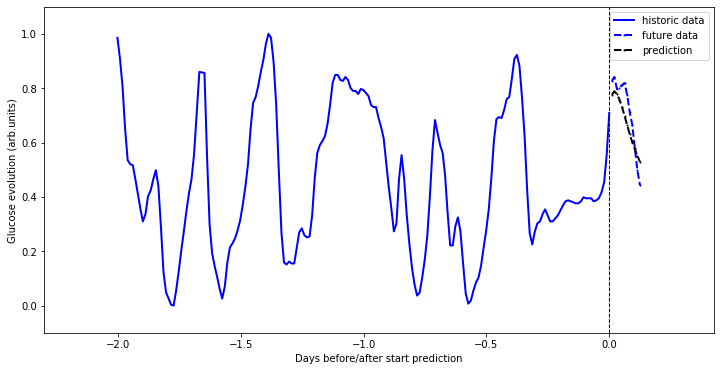

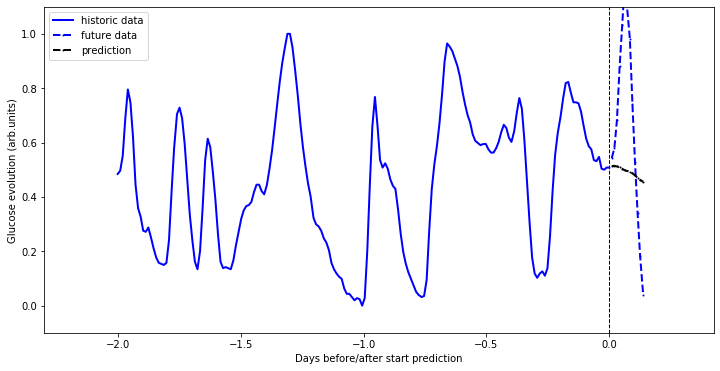

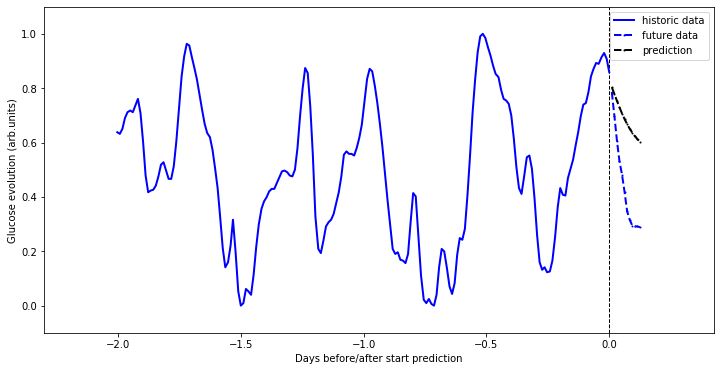

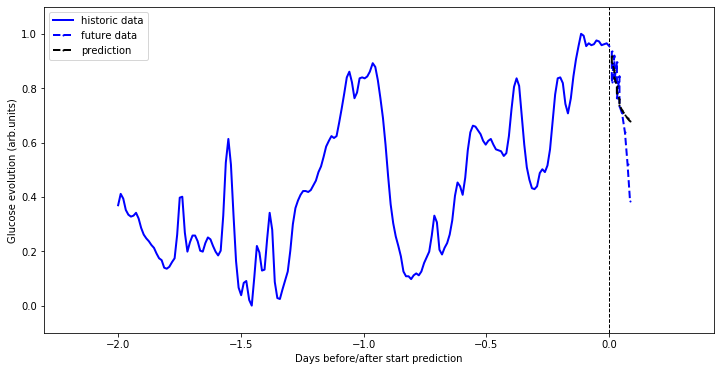

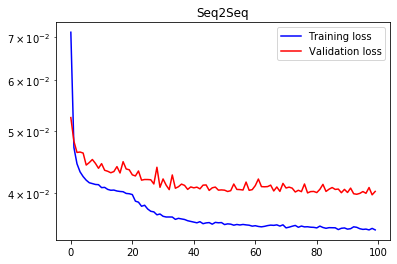

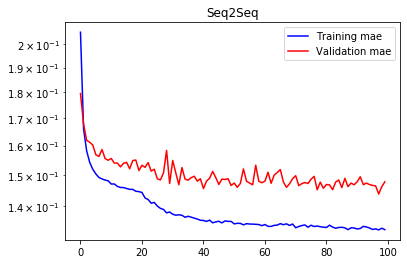

In [22]:
num_epochs = 100

num_layers_enc = 1
neurons = 200
num_features = 4
mn_dense = 0.5
mn_rec = 0.1
activation_dense = 'selu'
clip_value = 0.3
lr = 5e-4
dropout = 0.0
# better avoid using the recurrent_dropout, so as to take advantage of cuDNN implementation
recurrent_dropout = 0.0  
verbose = False

metric = 'mae'
loss = MSE

m, training_logs = train_seq2seq(train_data, vad_data, train, vad, 
    history, future, start_char, neurons, num_features, num_layers_enc, 
    activation_dense, mn_dense, mn_rec, dropout, recurrent_dropout, 
    lr, clip_value, num_epochs, train_batch, loss, metric, verbose)


Model: "seq2seq_training_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 300), (None, 366000      input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 12, 300)      0           lstm[0][0]                       
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 12, 300), (N 721200      repeat_vector[0][0]              
                                                                 lstm[0][1]  

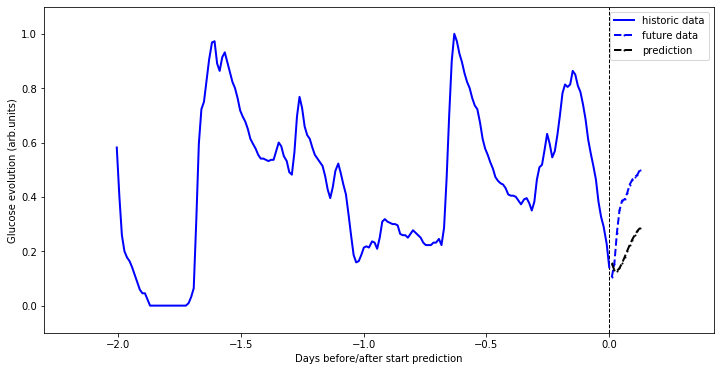

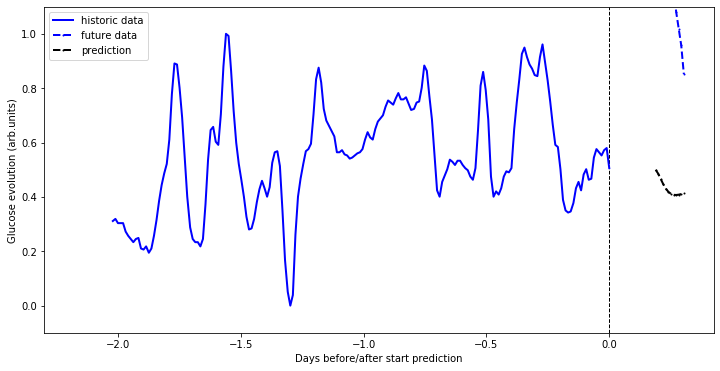

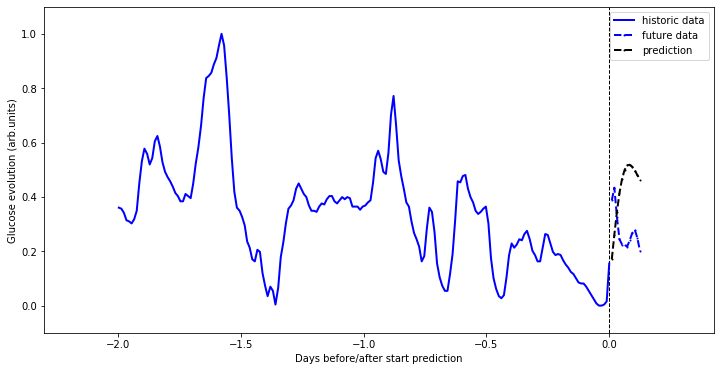

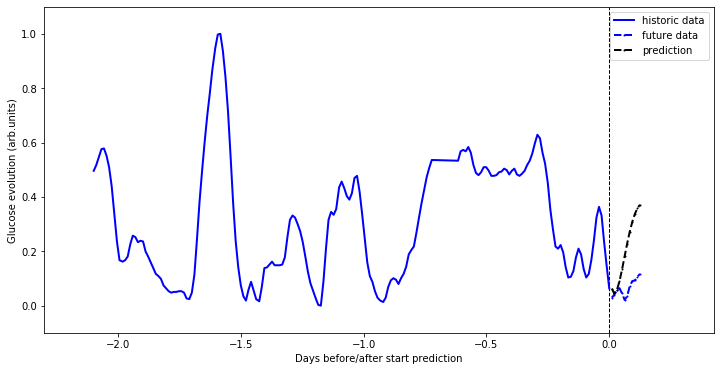

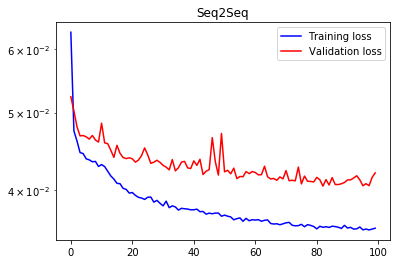

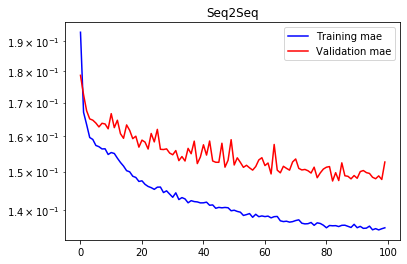

In [18]:
num_epochs = 100

num_layers_enc = 1
neurons = 300
num_features = 4
mn_dense = 0.5
mn_rec = 0.1
activation_dense = 'selu'
clip_value = 0.3
lr = 5e-4
dropout = 0.0
# better avoid using the recurrent_dropout, so as to take advantage of cuDNN implementation
recurrent_dropout = 0.0  
verbose = False

metric = 'mae'
loss = MSE

m, training_logs = train_seq2seq(train_data, vad_data, train, vad, 
    history, future, start_char, neurons, num_features, num_layers_enc, 
    activation_dense, mn_dense, mn_rec, dropout, recurrent_dropout, 
    lr, clip_value, num_epochs, train_batch, loss, metric, verbose)


Model: "seq2seq_training_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 50)     11000       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, None, 50)     20200       lstm[0][0]                       
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 50), (None,  20200       lstm_1[0][0]                     
_____________________________________________________________________________

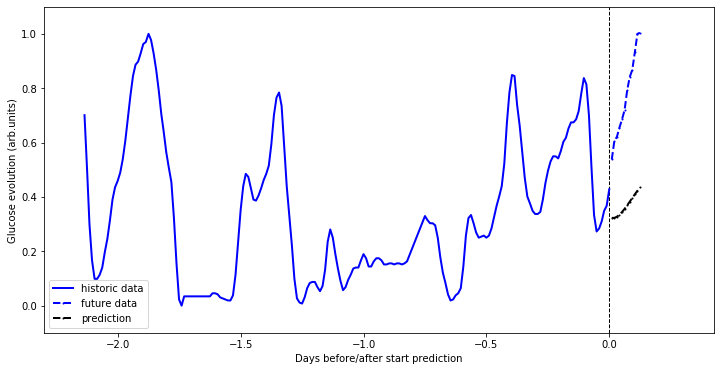

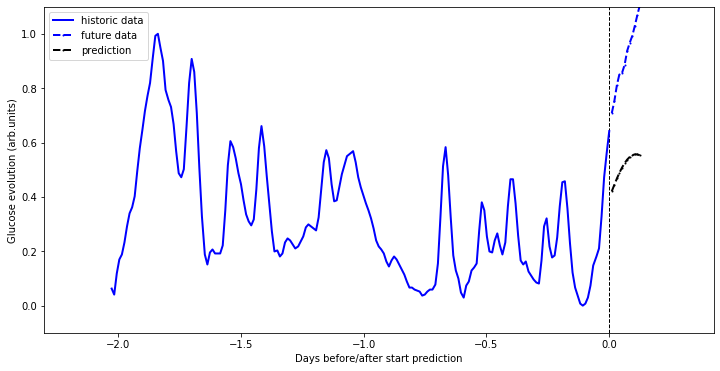

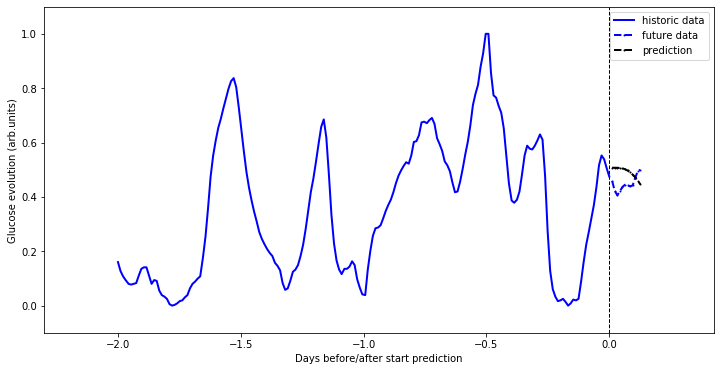

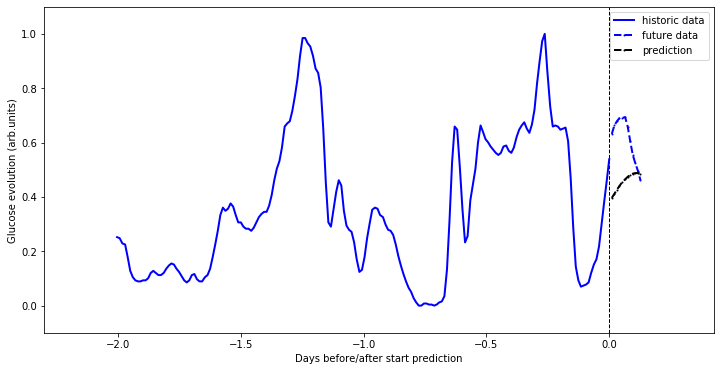

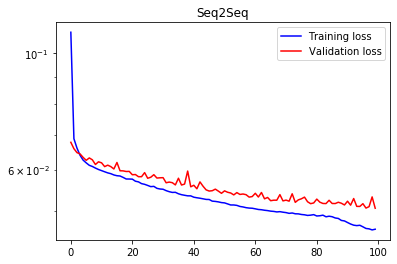

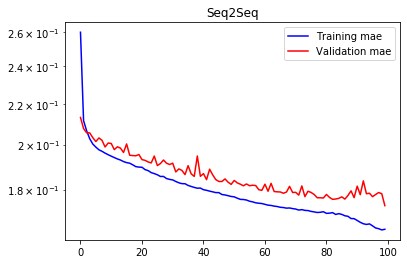

In [19]:
num_epochs = 100

num_layers_enc = 3
neurons = 50
num_features = 4
mn_dense = 0.5
mn_rec = 0.1
activation_dense = 'selu'
clip_value = 0.3
lr = 5e-4
dropout = 0.0
# better avoid using the recurrent_dropout, so as to take advantage of cuDNN implementation
recurrent_dropout = 0.0  
verbose = False

metric = 'mae'
loss = MSE

m, training_logs = train_seq2seq(train_data, vad_data, train, vad, 
    history, future, start_char, neurons, num_features, num_layers_enc, 
    activation_dense, mn_dense, mn_rec, dropout, recurrent_dropout, 
    lr, clip_value, num_epochs, train_batch, loss, metric, verbose)


## Seq2seq model with Teacher Forcing

### Models: encoder and decoder


In [0]:
def encoder(latent_dim, num_features, num_layers, mn_rec, dropout, recurrent_dropout):
    """
    Encode sequences with LSTMs 

    :param latent_dim: dimension of the encoding vectors
    :param num_features: number of input features
    :param num_layers: number of stack layers. Last layer only returns states
    :param mn_rec: max norm value used in the recurrent layers
    :param dropout: Float between 0 and 1. Fraction of the units to drop for the 
        linear transformation of the inputs.
    :param recurrent_dropout: Float between 0 and 1. Fraction of the units to 
        drop for the linear transformation of the recurrent state.
    :return encoder input and output states, and the inference model
    """
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None, num_features))

    # for loop to stack lstms, with returning sequences
    input_ = encoder_inputs
    for i in np.arange(num_layers-1):
       lstm_ = LSTM(latent_dim, return_sequences=True, 
                    kernel_constraint=max_norm(mn_rec),
                    recurrent_constraint=max_norm(mn_rec), dropout=dropout, 
                   recurrent_dropout=recurrent_dropout)
       input_ = lstm_(input_)

    # the last lstm returns the states, which will be use to feed the decoder
    encoder = LSTM(latent_dim, return_state=True, 
                   kernel_constraint=max_norm(mn_rec), 
                   recurrent_constraint=max_norm(mn_rec), dropout=dropout, 
                   recurrent_dropout=recurrent_dropout)
    _, state_h, state_c = encoder(input_)
    encoder_states = [state_h, state_c]

    # model to perform inference with the encoder
    encoder_model = Model(inputs=encoder_inputs, 
                          outputs=encoder_states, 
                          name='encoder_model_inference')

    return encoder_inputs, encoder_states, encoder_model

def decoder(encoder_states, latent_dim, activation_dense, mn_dense, mn_rec, 
            dropout, recurrent_dropout):
    """
    Decoder with LSTM 
    
    :param encoder_satates: list of tensors with the LSTM states (cell and hidden)
    :param latent_dim: dimension of the decoding vectors
    :param activation_dense: activation used in the last dense layer
    :param mn_dense: max norm value used in the dense layer
    :param mn_rec: max norm value used in the recurrent layers
    :param dropout: Float between 0 and 1. Fraction of the units to drop for the 
        linear transformation of the inputs.
    :param recurrent_dropout: Float between 0 and 1. Fraction of the units to 
        drop for the linear transformation of the recurrent state.
    :return decoder input and output sequences, and the inference model
    """
    # Define an input sequence and process it.
    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = Input(shape=(None, 1))

    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the 
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, 
                        kernel_constraint=max_norm(mn_rec), 
                        recurrent_constraint=max_norm(mn_rec), dropout=dropout, 
                        recurrent_dropout=recurrent_dropout)
    lstm_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(1, activation='selu', kernel_constraint=max_norm(mn_dense))
    decoder_outputs = decoder_dense(lstm_outputs)

    # model to perform inference with the decoder

    # inputs to cell and state (to be feed from the encoder last states, or others!)
    decoder_state_input_h = Input(shape=(latent_dim,))
    decoder_state_input_c = Input(shape=(latent_dim,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

    decoder_outputs_inference, state_h, state_c = decoder_lstm(
        decoder_inputs, initial_state=decoder_states_inputs)
    
    decoder_states_inference = [state_h, state_c]
    decoder_outputs_inference = decoder_dense(decoder_outputs_inference)
    decoder_model = Model(
        inputs=[decoder_inputs] + decoder_states_inputs,
        outputs=[decoder_outputs_inference] + decoder_states_inference,
        name='decoder_model_inference')
    
    return decoder_inputs, decoder_outputs, decoder_model

def seq2seq(history, future, latent_dim, num_features, num_layers_enc,
            activation_dense, mn_dense, mn_rec, dropout, recurrent_dropout):
    """

    :param history: number of steps of input sequence
    :param future: number of steps of output sequence
    :param latent_dim: dimension of the encoding/decoding vectors
    :param num_features: number of input features
    :param num_layers_enc: number of stack layers in the encoder. 
      Last layer only returns states
    :param activation_dense: activation used in the last dense layer
    :param mn_dense: max norm value used in the dense layer
    :param mn_rec: max norm value used in the recurrent layers
    :param dropout: Float between 0 and 1. Fraction of the units to drop for the 
        linear transformation of the inputs.
    :param recurrent_dropout: Float between 0 and 1. Fraction of the units to 
        drop for the linear transformation of the recurrent state.
    :return the model
    """
    clear_session()

    # encode
    encoder_inputs, encoder_states, encoder_model = encoder(latent_dim, 
        num_features, num_layers_enc, mn_rec, dropout, recurrent_dropout)
    print(encoder_model.summary())

    # decode
    decoder_inputs, decoder_outputs, decoder_model = decoder(encoder_states, 
        latent_dim, activation_dense, mn_dense, mn_rec, dropout, recurrent_dropout)
    print(decoder_model.summary())

    # Training model
    training_model = Model(inputs=[encoder_inputs, decoder_inputs], 
                           outputs=decoder_outputs, 
                           name='seq2seq_training_model')
    print(training_model.summary())

    return training_model, encoder_model, decoder_model

### Inference


In [0]:
def decode_sequence(input_seq, encoder_model, decoder_model, num_steps, start_char, batch_size):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((batch_size, 1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[:, 0, 0] = start_char

    # Sampling loop for a batch of sequences
    decoded_seq = np.zeros(shape=(batch_size, num_steps, 1), dtype=np.float)
    for i in np.arange(num_steps):
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)
        
        out = output_tokens[:, 0, 0]
        decoded_seq[:, i, 0] = out

        # Update the target sequence (of length 1).
        target_seq[:, 0, 0] = out

        # Update states
        states_value = [h, c]

    return decoded_seq

def inner_loop(decoded_seq, dataset, encoder_model, decoder_model, history, future, start_char, 
               start, end, num_seq, batch_size, verbose):
    for idx in np.arange(start, end, step=batch_size):
        if idx >0 and verbose and idx % 500 == 0:
            print("Predicted %s sequences" % idx)
        indices = np.arange(idx, idx+batch_size)
        input_seq = dataset[indices, :history, :]
        if batch_size == 1:
            input_seq = input_seq[np.newaxis, :, :]
        decoded_seq_ = decode_sequence(input_seq, encoder_model, decoder_model, 
                                       future, start_char, batch_size)
        decoded_seq[indices, :] = np.squeeze(decoded_seq_)
    return decoded_seq, indices[-1]
    
def decode_sequences(dataset, encoder_model, decoder_model, history, future, start_char, batch_size, verbose=False):
    num_seq = dataset.shape[0]
    num_steps = num_seq // batch_size
    decoded_seq = np.zeros(shape=(num_seq, future))
    
    start = 0
    decoded_seq, last_idx = inner_loop(decoded_seq, dataset, encoder_model, decoder_model, 
                                        history, future, start_char, start, num_seq-batch_size,
                                        num_seq, batch_size, verbose)
    batch_size = num_seq - last_idx -1 
    if batch_size > 0:
        start = last_idx+1
        decoded_seq, last_idx = inner_loop(decoded_seq, dataset, encoder_model, decoder_model, 
                                        history, future, start_char, start, num_seq,
                                        num_seq, batch_size, verbose)            
    return decoded_seq

### Training

In [0]:
def train_seq2seq(train_data, vad_data, train, vad, history, future, start_char, 
                  latent_dim, num_features, num_layers_enc, 
                  activation_dense, mn_dense, mn_rec, dropout, recurrent_dropout, 
                  lr, clip_value, num_epochs, train_batch, prediction_batch, 
                  epochs_to_validation, loss, metric, verbose):

    m, enc, dec = seq2seq(history, future, latent_dim=neurons, num_features=num_features, 
                          num_layers_enc=num_layers_enc, activation_dense=activation_dense, 
                          mn_dense=mn_dense, mn_rec=mn_rec, 
                          dropout=dropout, recurrent_dropout=recurrent_dropout)

    m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr, clipvalue=clip_value), 
              loss=loss, metrics=[metric])

    training_logs = {'loss': [], 'val_loss': [], metric: [], 'val_{}'.format(metric): []}
    err_logs = np.zeros(shape=(num_epochs//epochs_to_validation, 3))
    k = 0
    for epoch in np.arange(num_epochs):
        print("Epoch number %s" %epoch)
        h = m.fit(x=train_data[0], y=train_data[1], batch_size=train_batch, epochs=1, 
                  validation_data=vad_data)
        training_logs = {k: v + h.history[k] for k, v in training_logs.items()}

        if (epoch +1) % epochs_to_validation == 0:
            prediction_train = decode_sequences(train, enc, dec, history, future, start_char, 
                                                batch_size=prediction_batch, verbose=verbose)
            err_train = mae(train, prediction_train, history, future)

            prediction_vad = decode_sequences(vad, enc, dec, history, future, start_char, 
                                              batch_size=prediction_batch, verbose=verbose)
            err_vad = mae(vad, prediction_vad, history, future)
            print('For epoch %s, the error in train and validation is MAE=(%.3f, %.3f)' % (epoch+1, err_train, err_vad))
            err_logs[k, :] = np.array([epoch, err_train, err_vad])
            k += 1

    for _ in np.arange(4):
        plot_results(vad, prediction_vad, history, future)

    plot_train_history(training_logs, 'Seq2Seq', metric='loss')
    plot_train_history(training_logs, 'Seq2Seq', metric=metric)
    plot_metric(err_logs)
    return m, enc, dec, prediction_vad, err_logs, training_logs

Model: "encoder_model_inference"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 4)]         0         
_________________________________________________________________
lstm (LSTM)                  [(None, 50), (None, 50),  11000     
Total params: 11,000
Trainable params: 11,000
Non-trainable params: 0
_________________________________________________________________
None
Model: "decoder_model_inference"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 50)]         0             

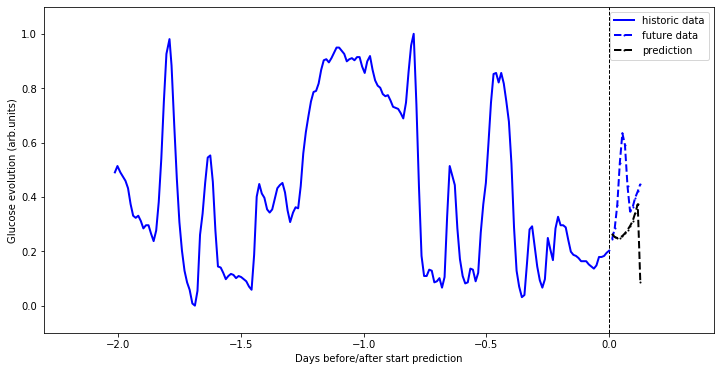

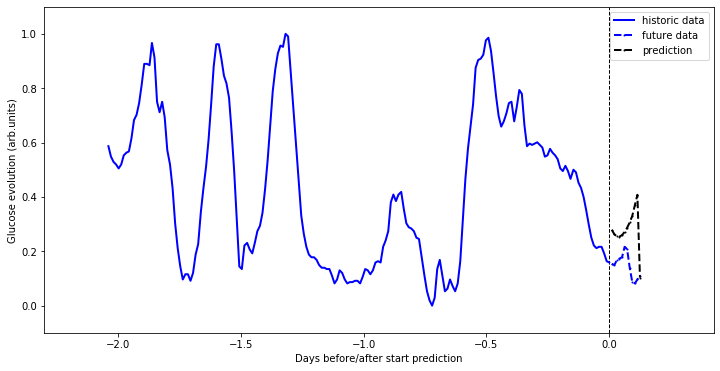

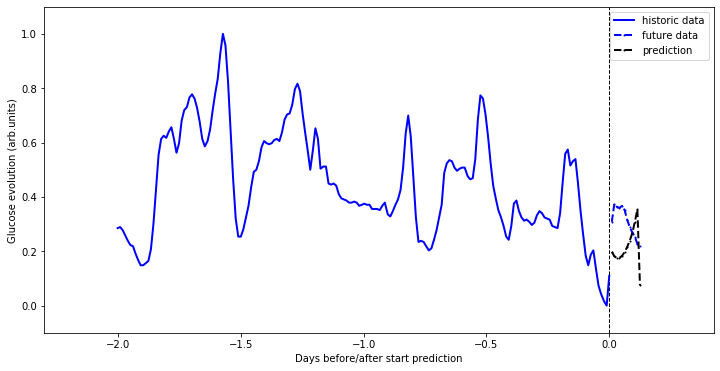

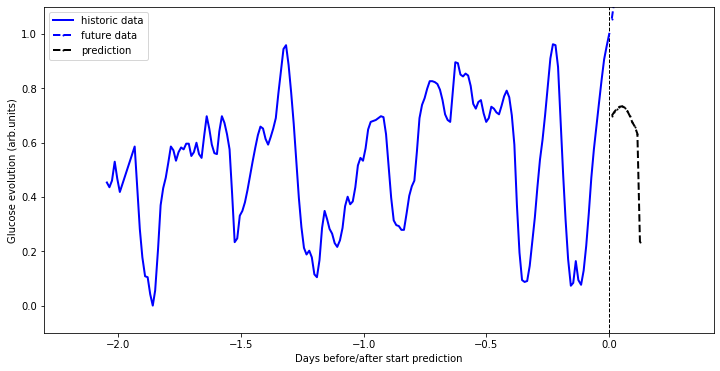

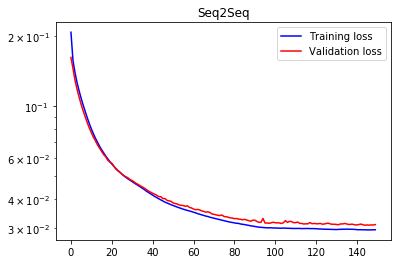

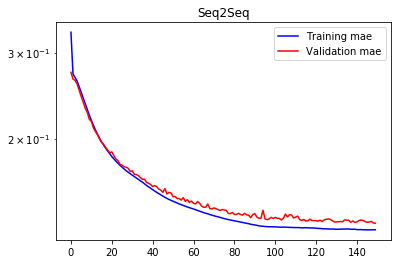

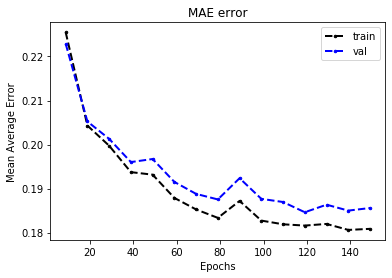

In [0]:
num_epochs = 150

num_layers_enc = 1
neurons = 50
num_features = 4
mn_dense = 0.3
mn_rec = 0.1
activation_dense = 'selu'
clip_value = 0.3
lr = 5e-4
dropout = 0.0
# better avoid using the recurrent_dropout, so as to take advantage of cuDNN implementation
recurrent_dropout = 0.0  
verbose = False

prediction_batch = 500
epochs_to_validation = 10
metric = 'mae'
loss = MSE

m50, enc50, dec50, prediction_vad50, err_logs50, training_logs50 = train_seq2seq(train_data, vad_data, train, vad, 
    history, future, start_char, neurons, num_features, num_layers_enc, 
    activation_dense, mn_dense, mn_rec, dropout, recurrent_dropout, 
    lr, clip_value, num_epochs, train_batch, prediction_batch, 
    epochs_to_validation, loss, metric, verbose)


Model: "encoder_model_inference"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 4)]         0         
_________________________________________________________________
lstm (LSTM)                  [(None, 50), (None, 50),  11000     
Total params: 11,000
Trainable params: 11,000
Non-trainable params: 0
_________________________________________________________________
None
Model: "decoder_model_inference"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 50)]         0             

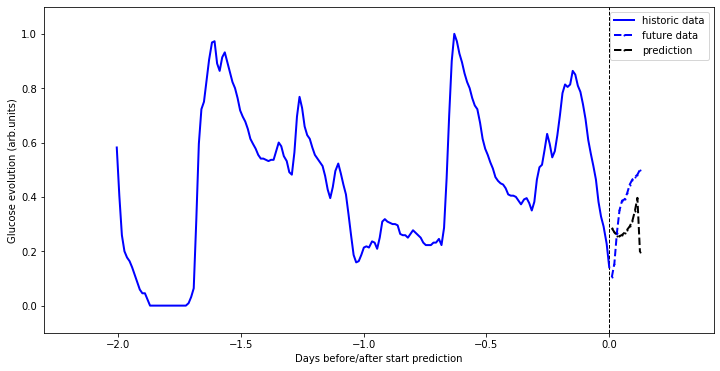

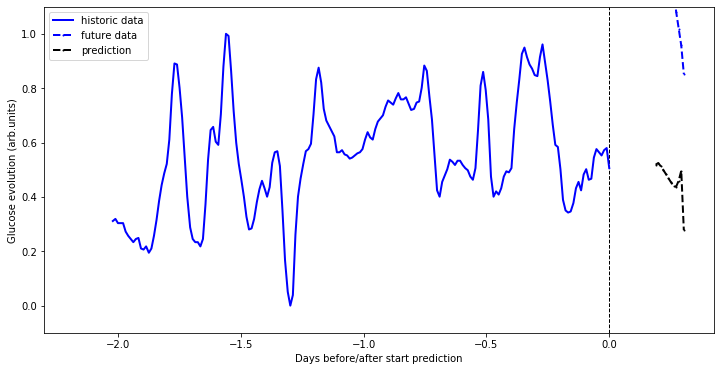

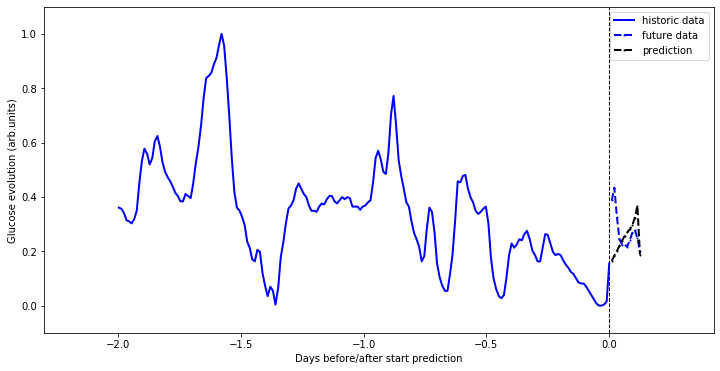

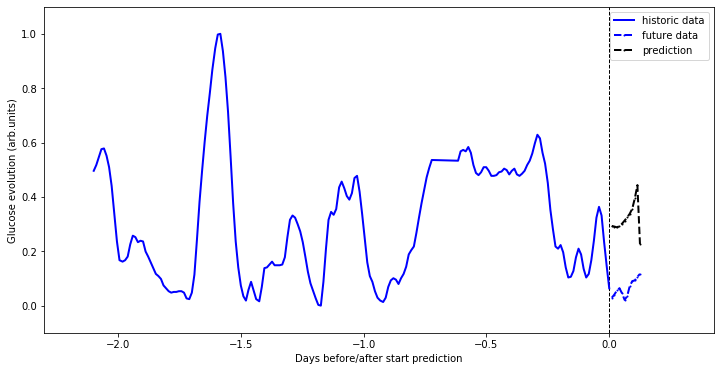

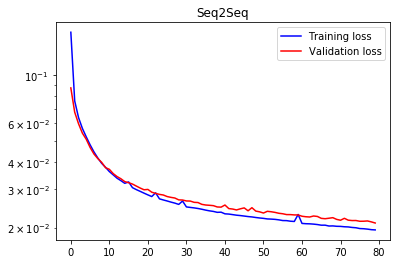

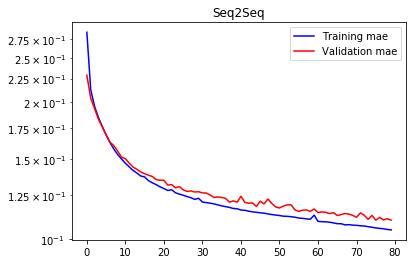

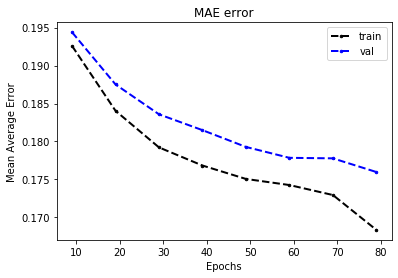

In [0]:
num_epochs = 80

num_layers_enc = 1
neurons = 50
num_features = 4
mn_dense = 0.3
mn_rec = 0.2
activation_dense = 'selu'
clip_value = 0.3
lr = 1e-3
dropout = 0.0
# better avoid using the recurrent_dropout, so as to take advantage of cuDNN implementation
recurrent_dropout = 0.0  
verbose = False

prediction_batch = 500
epochs_to_validation = 10
metric = 'mae'
loss = MSE

m50, enc50, dec50, prediction_vad50, err_logs50, training_logs50 = train_seq2seq(train_data, vad_data, train, vad, 
    history, future, start_char, neurons, num_features, num_layers_enc, 
    activation_dense, mn_dense, mn_rec, dropout, recurrent_dropout, 
    lr, clip_value, num_epochs, train_batch, prediction_batch, 
    epochs_to_validation, loss, metric, verbose)


### Retrain best model with train and vad data

In [0]:
a1 = np.concatenate([train_data[0][0], vad_data[0][0]], axis=0)
a2 = np.concatenate([train_data[0][1], vad_data[0][1]], axis=0)
b = np.concatenate([train_data[1], vad_data[1]], axis=0)
train_vad_data = ((a1, a2), b)

msg = "Shapes of train+vad data are: input_enc: {}, input_dec: {} and output_dec: {}"
msg = msg.format(train_vad_data[0][0].shape, train_vad_data[0][1].shape, train_vad_data[1].shape)
print(msg)

Shapes of train+vad data are: input_enc: (93903, 144, 4), input_dec: (93903, 17, 1) and output_dec: (93903, 17, 1)


In [0]:
num_epochs = 150

num_layers = 1
neurons = 200
mn_dense = 0.5
mn_rec = 0.2

full_model, full_enc, full_dec = seq2seq(history, future, latent_dim=neurons, num_features=4, 
                      num_layers_enc=num_layers, activation_dense='elu', 
                      mn_dense=mn_dense, mn_rec=mn_rec)
full_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4, clipvalue=0.3), 
          loss=MSE, metrics=['mean_absolute_error'])
h = full_model.fit(x=train_vad_data[0], y=train_vad_data[1], batch_size=train_batch, epochs=num_epochs)

### Save best model

In [0]:
root = "/content/drive/My Drive/Colab Notebooks/sugar_level_prediction/models/"
outfolder = os.path.join(root, "noise_%s_train_replace_%s" %(noise, replace))
modelname = "layers_%s_neurons_%s_mn-dense_%.1f_mn-rec_%.1f" %(num_layers, neurons, mn_dense, mn_rec)
outpath = os.path.join(outfolder, modelname)

import re
outpath_bash = re.sub(" ", "\ ", outpath)

!mkdir -p $outpath_bash

full_model.save(os.path.join(outpath, 'seq2seq_model.h5'))
full_enc.save(os.path.join(outpath, 'encoder_model.h5'))
full_dec.save(os.path.join(outpath, 'decoder_model.h5'))

### Evaluate on the test set


In [0]:
prediction_test = decode_sequences(test, enc, dec, history, future, start_char, 
                                   batch_size=500, verbose=True)
err_test = mae(test, prediction_test, history, future)

print("MAE in test set is %.3f" %err_test)

Predicted 500 sequences
Predicted 1000 sequences
Predicted 1500 sequences
Predicted 2000 sequences
Predicted 2500 sequences
Predicted 3000 sequences
Predicted 3500 sequences
Predicted 4000 sequences
Predicted 4500 sequences
Predicted 5000 sequences
Predicted 5500 sequences
Predicted 6000 sequences
Predicted 6500 sequences
Predicted 7000 sequences
Predicted 7500 sequences
Predicted 8000 sequences
Predicted 8500 sequences
Predicted 9000 sequences
Predicted 9500 sequences
Predicted 10000 sequences
MAE in test set is 0.240


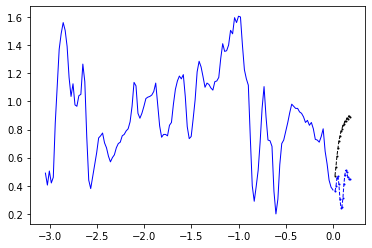

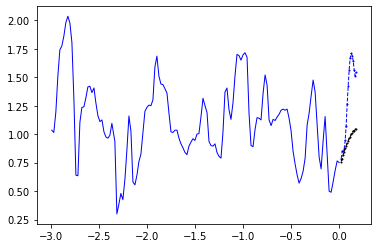

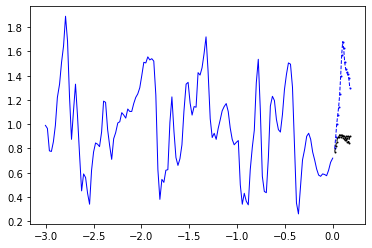

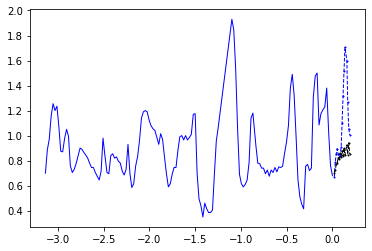

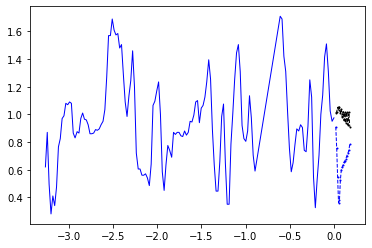

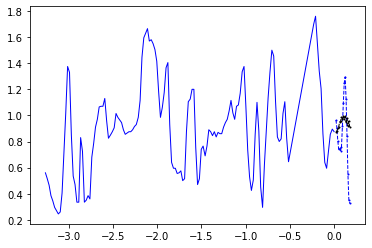

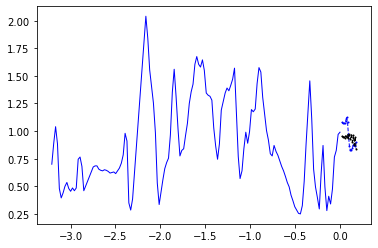

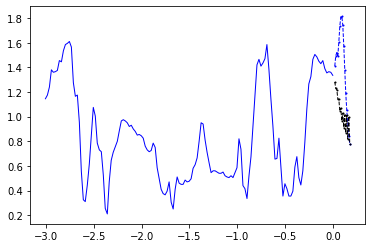

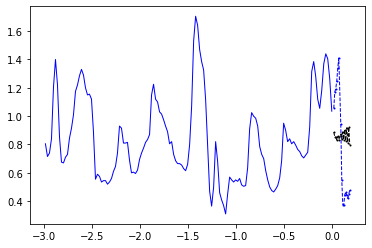

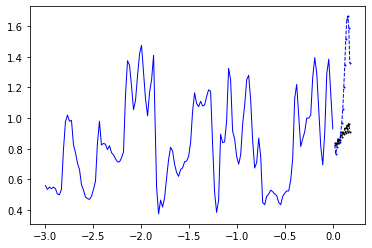

In [0]:
for _ in np.arange(10):
  plot_results(test, prediction_test, history, future)

## Seq2seq with Curriculum Learning

https://www.tensorflow.org/tutorials/text/text_generation

https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/

